# V2: SCF optimization with VAMPyR

## V2.1: Hydrogen atom

In order to solve the one-electron Schr\"{o}dinger equation in MWs we reformulate them in an integral form [1].

\begin{equation}
 \phi = -2\hat{G}_{\mu}\hat{V}\phi
\end{equation}

Where $\hat{V}$ is the potential acting on the system, $\phi$ is the wavefunction, $\hat{G}$ is the Helmholtz integral operator, where its kernel is defined as $G_\mu(r - r') = \frac{\exp(-\mu |r - r'|)}{4\pi |r - r'|}$
and $\mu$ is a parameter defined above through the energy.

The Helmholtz operator is already implemented in vampyr, therefore the only things you need are the integral KS equation and the definition of $\mu$ 

\begin{equation}
     \mu = \sqrt{-2E}
\end{equation}

The way you initialize the Helmholtz operator is as follows
```
H = vp.HelmholtzOperator( mra, exp=mu, prec=eps )
```
where `mu` is the $\mu$ is the parameter defined above, mra you have seen before, and `eps` is the desired threshold precision. This operator is applied the same way you applied the vp.ScalingProjector earlier.

In this exercise you will be solving the KS equation iteratively for a simple system, the Hydrogen atom. This means that you only have the nuclear potential to take into account for the potential term in the KS equation.

\begin{align}
    V_{nuc}(\mathbf{r}) = -\frac{1}{|\mathbf{r}|}
\end{align}

We will also be working with a single orbital, of which the initial guess is

\begin{align}
    \phi_0(\mathbf{r}) = e^{-|\mathbf{r}|^2}
\end{align}
where 
\begin{align}
    |\mathbf{r}| = \sqrt{x^2 + y^2 + z^2}
\end{align}

The orbital update is defined as follows
\begin{align}
    \Delta\tilde{\phi}^n &= -2\hat{G}[V_{nuc}\phi^n] - \phi^n \\
    \Delta\tilde{\phi}^n &= \tilde{\phi}^{n+1} - \phi^n
\end{align}
where we use \~ to denote a function that is **not** normalized, and $n$ is the iteration index.

What you need to do in this exercise is
1. Make a nuclear potential as a python function
2. Make an initial guess for the orbital as a python function (hint use `np.exp` )
3. Create a Helmholtz operator with $\mu$ as shown above, use the exact value of $\epsilon$ for a hydrogen atom ($-0.5$ A.U.)
4. Project both nuclear potential and orbital through vampyr
5. Compute new orbital through application of the Helmholtz operator
6. Compute the size of the orbital update $||\tilde{\phi}^{n+1} - \phi^n||$
7. Normalize the orbital $\phi^{n+1} = \tilde{\phi}^{n+1}/||\tilde{\phi}^{n+1}||$
8. Update orbital $\phi^{n+1} \rightarrow \phi^{n}$ for next iteration
9. Repeat steps 5-8 until your orbital energies have converged

The convergence criterion is the norm of $\Delta \phi^n$, but you should start by looping a set amount of times before trying the threshold.

iteration: 0    Norm: 1.0169878647963155   Update: 0.36587448758324526
iteration: 1    Norm: 1.05378724366613   Update: 0.1645602919169264
iteration: 2    Norm: 1.0333052083373122   Update: 0.07745384733946888
iteration: 3    Norm: 1.0177852625944193   Update: 0.03773184427622537
iteration: 4    Norm: 1.009133801970682   Update: 0.018679599807216507
iteration: 5    Norm: 1.0046250024064414   Update: 0.009312391569940485
iteration: 6    Norm: 1.0023286022303974   Update: 0.0046560291118413555
iteration: 7    Norm: 1.0011702338140926   Update: 0.002330798059637438
iteration: 8    Norm: 1.0005885273891015   Update: 0.0011676771000041874
iteration: 9    Norm: 1.0002970414270043   Update: 0.0005855858334011854


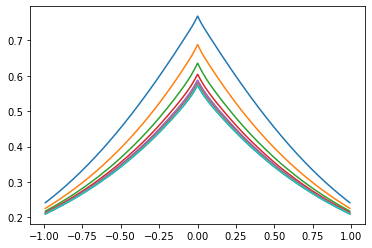

In [4]:
from vampyr import vampyr3d as vp
import numpy as np
import matplotlib.pyplot as plt

r_x = np.linspace(-0.99, 0.99, 1000) # create an evenly spaced set of points between -0.99 and 0.99
r_y = np.zeros(1000)
r_z = np.zeros(1000)
r = [r_x, r_y, r_z]

# Analytic nuclear potential
def f_nuc(r):
    R = np.sqrt(r[0]*r[0] + r[1]*r[1] + r[2]*r[2])
    return -1.0 / R

# Analytic guess for solution
def f_phi(r):
    R = np.sqrt(r[0]*r[0] + r[1]*r[1] + r[2]*r[2])
    return np.exp(-R*R)


# Global parameters
k = 7                        # Polynomial order
L = [-20,20]                 # Simulation box size
epsilon = 1.0e-4             # Relative precision

# Define MRA and multiwavelet projector
MRA = vp.MultiResolutionAnalysis(order=k, box=L)
P_eps = vp.ScalingProjector(mra=MRA, prec=epsilon)

# Project analytic nuclear potential
V_nuc = P_eps(f_nuc)

# Initial guess for the wavefunction
phi_n = P_eps(f_phi)
phi_n.normalize()

# Prepare Helmholtz operator
E = -0.5
mu = np.sqrt(-2*E)
H = vp.HelmholtzOperator(mra=MRA, exp=mu, prec=epsilon)
    
# Minimization loop
thrs = 1.0e-3
update = 1.0
i = 0
while (update > thrs):
    # Apply Helmholtz operator
    Vphi = V_nuc * phi_n
    phi_np1 = -2*H(Vphi)
    norm = phi_np1.norm()
    
    # Compute orbital and energy updates
    dPhi_n = phi_np1 - phi_n
    update = dPhi_n.norm()
    
    # Prepare for next iteration
    phi_n = phi_np1
    phi_n.normalize()
    phi_n.crop(epsilon)  # Truncate MW exansion based on precision
    
    phi_n_plt = [phi_n([x, 0.0, 0.0]) for x in r_x]
    plt.plot(r_x, phi_n_plt)
    
    print("iteration: {}    Norm: {}   Update: {}".format(i, norm, update))
    i += 1

plt.show()

I don't know if I want to add more than this right now


## 4 Sources


[1] Stig Rune Jensen, Santanu Saha, José A. Flores-Livas, William Huhn, Volker Blum, Stefan Goedecker, and Luca Frediani The Elephant in the Room of Density Functional Theory Calculations. The Journal of Physical Chemistry Letters 2017 8 (7), 1449-1457
DOI: 10.1021/acs.jpclett.7b00255
